In [39]:
import math
import warnings

## from IPython.display import displayomm
from matplotlib import pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std



# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [4]:
data_path = ('./table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

df_raw = pd.read_excel(data_path, skiprows = 4)


In [5]:
print(list(df_raw))
print('Number of rows {} and number of columns {}'.format(df_raw.shape[0], df_raw.shape[1]))

['City', 'Population', 'Violent\ncrime', 'Murder and\nnonnegligent\nmanslaughter', 'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2', 'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary', 'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3']
Number of rows 351 and number of columns 13


## Data preperation 

In this part I will prepare the data to be able to use multivariable_regression. 
I will explore the data after taking the features I will use. No need to fix the features that are unnecessery for now. 

In [6]:
## getting the columns we need for the model
df_task = df_raw[['City','Population', 'Murder and\nnonnegligent\nmanslaughter', 
                  'Robbery', 'Property\ncrime','Burglary']].copy()
df_task.columns = ['City','Population', 'Murder', 'Robbery', 'propCrime','Burglary']

In [7]:
df_task = df_task.dropna()


In [8]:
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


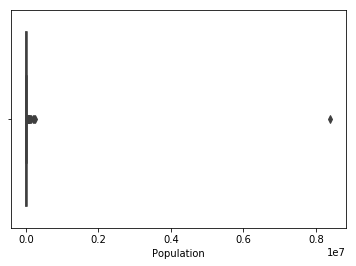

In [9]:
## using a boxplot can show if there are values that are abnormal
p1= sns.boxplot(df_task["Population"])

plt.show()

In [10]:
## There is a value that seems to be much higher than the rest. 

df_task.loc[df_task['Population'] == df_task['Population'].max(), :]

,City,Population,Murder,Robbery,propCrime,Burglary
216,New York,8396126.000,335.000,19170.000,141971.000,16606.000


In [66]:
## I will drop the row of new york since it is affecting the model

df_task = df_task.loc[df_task['City'] != 'New York', :].

/Users/Badrshuaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


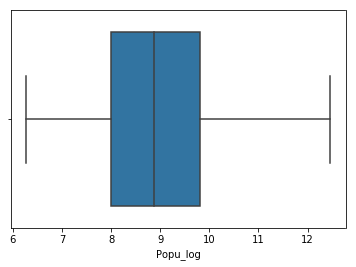

In [67]:
## New york has more than 8 milion in population. if we take the log of the population we 
## can graph the boxplot again and we will be able to see more info
df_task['Popu_log'] = np.log(df_task['Population'])

p2= sns.boxplot(df_task["Popu_log"])

plt.show()

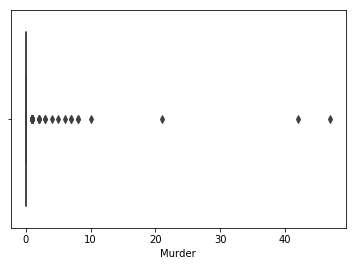

In [68]:
## Even with 
p3= sns.boxplot(df_task["Murder"])

plt.show()

In [69]:
df_task.loc[df_task['Murder'] == df_task['Murder'].max(), :]



,City,Population,Murder,Robbery,propCrime,Burglary,Popu_log,Murder_sqrt,Pop_squared,robb_cat,murd_cat
35,Buffalo,258789.000,47.000,1322.000,12491.000,3458.000,12.464,6.856,66971746521.000,1,1


In [70]:
df_task['Murder_sqrt'] = np.sqrt(df_task['Murder'])

/Users/Badrshuaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


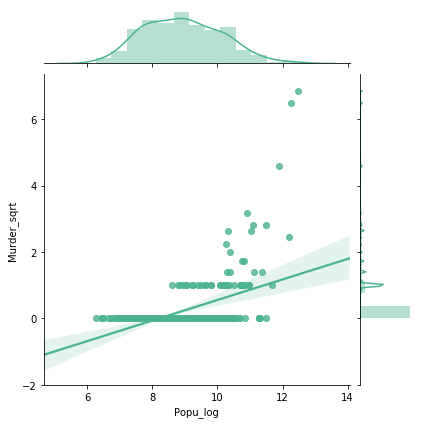

In [71]:
x = df_task['Popu_log']
y = df_task['Murder_sqrt']
sns.jointplot(x, y, kind="reg", color="#4CB391")

plt.show()


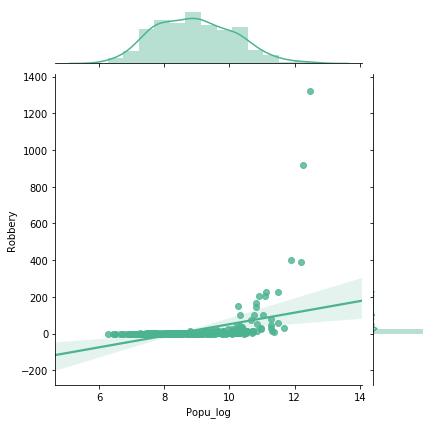

In [72]:

y2 = df_task['Robbery']
sns.jointplot(x, y2, kind="reg", color="#4CB391")

plt.show()



## Feature Engineering
Although New york seems to be an anamolous value, it is still necessery for our model. I have used the log function to create an easy to visiulize version of the population.
in this part i will create the three new features. Population ^ 2 and two catagorical features from the robbery and Murder features. 

In [73]:
## 1. creating population squared
df_task['Pop_squared'] = np.square(df_task['Population'])

## 2. creating Robbery catagory with values == 0 are 0 and values > 0 are 1

df_task['robb_cat'] = (df_task['Robbery'] != 0) * 1

## 3. creating Murder catagory with values == 0 are 0 and values > 0 are 1

df_task['murd_cat'] = (df_task['Murder'] != 0) * 1

/Users/Badrshuaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Badrshuaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Badrshuaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

In [74]:
df = df_task[df_task.isnull().any(axis=1)]

df.head()

,City,Population,Murder,Robbery,propCrime,Burglary,Popu_log,Murder_sqrt,Pop_squared,robb_cat,murd_cat


## The Multivariable Regression model
In this part i will fit the model using the LinearRegression module

In [19]:
regr = linear_model.LinearRegression()
Y = df_task['propCrime'].values.reshape(-1, 1)
X = df_task[['Population','Pop_squared','robb_cat', 'murd_cat']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  3.46570268e-02  -2.11108019e-09  -9.62774363e+01   1.51866535e+01]]

Intercept: 
 [-109.57533562]

R-squared:
0.996124710499


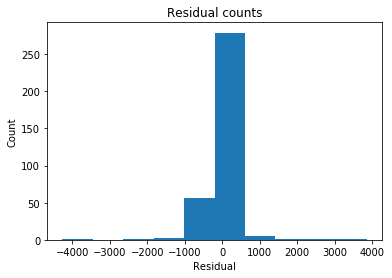

In [20]:
predicted = regr.predict(X).ravel()
actual = (df_task['propCrime'])

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

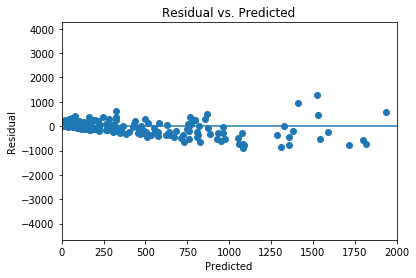

In [21]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.xlim(0,2000)
plt.show()




## Validation

In this part i will use cross validation, holdout and other technique to evaluate the model.

In [38]:
## Holdout validation
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=30)
print('With 10% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X,Y)))

With 20% Holdout: 0.794338257575
Testing on Sample: 0.996124710499


In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=10)

array([  7.60520539e-01,   8.23393294e-01,  -9.24026836e-03,
         5.04913291e-01,   4.74244233e-01,   4.19961624e-01,
        -3.37873798e+03,   8.21731323e-01,   8.86333090e-01,
        -9.81038943e-01])

From the results of the holdout and corss validation, there seems to be a major error in parts of the data that makes the regression line performs so badly, worst than a horizental line. 

In [40]:
## I will use smf linear regression to see more details about our outcome
linear_formula = ' propCrime ~ Population+ Pop_squared+ robb_cat + murd_cat'
# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df_task).fit()

In [41]:
lm.params

Intercept     -109.575
Population       0.035
Pop_squared     -0.000
robb_cat       -96.277
murd_cat        15.187
dtype: float64

In [42]:
lm.rsquared

0.99612471049887086

In [43]:
lm.pvalues

Intercept     0.008
Population    0.000
Pop_squared   0.000
robb_cat      0.091
murd_cat      0.863
dtype: float64

In [50]:
## I will use smf linear regression to see more details about our outcome
linear_formula = ' propCrime ~ Population+ Pop_squared'
# Fit the model to our data using the formula.
lm2 = smf.ols(formula=linear_formula, data=df_task).fit()

In [51]:
display(lm2.params)
display(lm2.rsquared)
display(lm2.pvalues)

Intercept     -156.964
Population       0.034
Pop_squared     -0.000
dtype: float64

0.99609215219612435

Intercept     0.000
Population    0.000
Pop_squared   0.000
dtype: float64

In [56]:
X2 = df_task[['Population','Pop_squared']]
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=30)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X2, Y).score(X2,Y)))

With 20% Holdout: 0.801910827754
Testing on Sample: 0.996092152196


In [57]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X2, Y, cv=10)

array([  7.63732525e-01,   8.25944305e-01,   1.10854635e-01,
         4.83936375e-01,   5.07749653e-01,   4.08412075e-01,
        -2.74401065e+03,   8.22380421e-01,   8.83114331e-01,
        -9.17775521e-01])

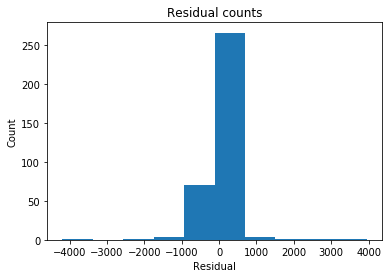

In [58]:
predicted = regr.predict(X2).ravel()
actual = (df_task['propCrime'])

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

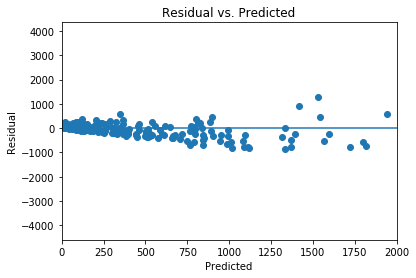

In [59]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.xlim(0,2000)
plt.show()



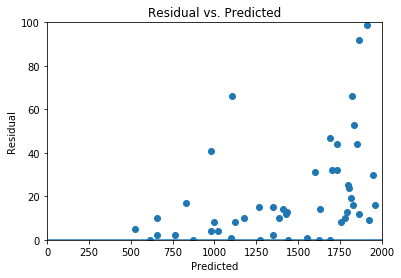

In [63]:
plt.scatter(df_task["Population"], df_task['propCrime'])
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.xlim(0,2000)
plt.ylim(0,100)
plt.show()